In [3]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import warnings 
warnings.filterwarnings("ignore")

In [4]:
# Read data
df = pd.read_csv('train_1.csv')

# Fill missing values
df = df.fillna(0)

# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')

# Setting 'Date' column as the index 
df_reshaped['Date'] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')

In [5]:
# Time-series of page with maximum views
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Views')['Page'].tolist()

top_page_df = df_reshaped[df_reshaped.Page == top_pages_list[0]]
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)

## Anomaly detection

In [6]:
# Detecting anomalies in the data, removing anomalies and filling missing values with rolling mean
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

In [8]:
# Convert dataset into suitable form to train the model
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

def transform_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7

X_train, y_train = transform_dataset(train, train.Views, time_steps)
X_test, y_test = transform_dataset(test, test.Views, time_steps)

## LSTM

In [9]:
# Build the model
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.RMSprop()
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 405 samples, validate on 46 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
405/405 [==============================] - 1s 2ms/sample - loss: 128.8063 - val_loss: 110.7118
Epoch 2/20
405/405 [==============================] - 0s 435us/sample - loss: 15.5781 - val_loss: 52.5924
Epoch 3/20
405/405 [==============================] - 0s 431us/sample - loss: 4.0243 - val_loss: 31.5697
Epoch 4/20
405/405 [==============================] - 0s 426us/sample - loss: 2.4279 - val_loss: 26.2527
Epoch 5/20
405/405 [==============================] - 0s 430us/sample - loss: 2.3140 - val_loss: 24.5022
Epoch 6/20
405/405 [==============================] - 0s 428us/sample - loss: 2.2859 - val_loss: 23.7207
Epoch 7/20
405/405 [==============================] - 0s 429us/sample - loss: 2.1792 - val_loss: 22.5963
Epoch 8/20
405/405 [==============================] - 0s 428us/sample - loss: 2.1318 - val_loss: 21.6023
Epoch 9/20
405/405 [==============================] - 0s 428us/sa

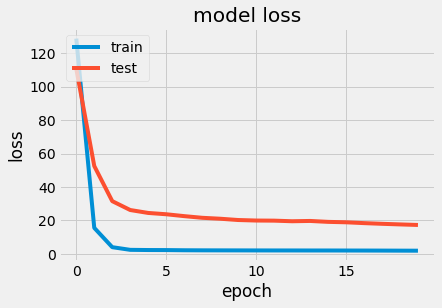

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# Forecasting using test data
y_pred = model.predict(X_test)

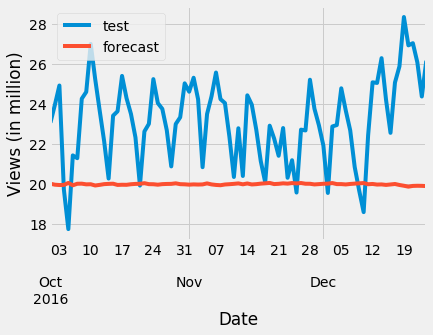

In [14]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.show()

In [15]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))

RMSE:3.836015794273304
